# GIA - Práctica 2
## Segmentación

El objetivo de esta práctica es el desarrollo de una metodología para la segmentación automática de las regiones de fluido patológico en imágenes OCT.


In [1]:
# Connect to drive

from google.colab import drive
import os

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P2/'

print('\nChange the directory to project route')
%cd $route

Mounted at /content/gdrive

Change the directory to project route
/content/gdrive/MyDrive/GIA/VCA/P2


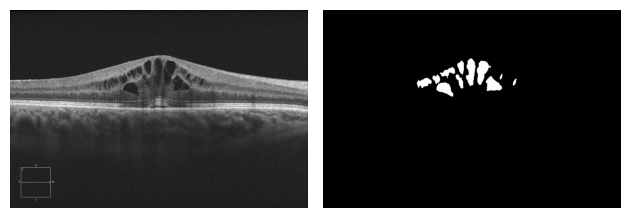

In [2]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

im = plt.imread(f"{route}OCT-dataset/images/sample_01.jpg")
mask = plt.imread(f"{route}OCT-dataset/masks/sample_01.jpg")
show(im, mask)

**Sugerencia**: Para el cálculo de métricas de rendimiento se puede utilizar la siguiente función auxiliar que permite obtener la máscara de segmentación a partir de las salidas de la red. La salida de la red es un valor positivo en coma flotante. La función sigmoidea restringe el dominio de salida entre 0 y 1. Como la máscara de salida es binaria, usamos un umbral para establecer los valores de la máscara de salida en 0 ó 1. Ten en cuenta que tal vez tengas que ajustar el umbral por defecto.

In [3]:
# Aux function to get binary segmentation mask
import torch
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold) * 1.0
    return masks

# Aux function to show results
def show_result(orig, gt, prediction, title=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    ax = axes.ravel()

    images = [orig, gt, prediction, orig*prediction]
    titles = ['Orig', 'Gt', 'Result', 'Overlap']
    for i, (im, tit) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='gray')
        ax[i].set_title(tit)
        ax[i].axis('off')
    plt.show()

## UNet
UNet es una red convolucional diseñada para la segmentación de imágenes biomédicas. Sus tasas de éxito son altas incluso con pocas imágenes en el conjunto de entrenamiento.
En esta práctica abordaremos la tarea de segmentación usando una UNet. Los pasos generales a seguir son los siguientes:
1. Definir la arquitectura de red
2. Creación de dataset
   - Generar conjuntos de entrenamiento, validación y test
3. Entrenar la red
4. Seleccionar modelo en base a conjunto de validación
5. Test del modelo seleccionado

### Paso 1: Arquitectura de red

Puedes implementar la red desde cero a partir de la descripción proporcionada en el [paper original](https://arxiv.org/abs/1505.04597), utilizar algún paquete de python que proporciona la implementación y modelos preentrenados como [Segmentation Models based on PyTorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/) o utilizar el código fuente disponible online de alguna de las arquitecturas de red típicas. Por ejemplo, la siguiente implementación adaptada [de este código fuente](https://github.com/usuyama/pytorch-unet).

In [4]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Paso 2: Creación de Dataset
En este paso, vamos a cargar los datos extendiendo la clase `Dataset` de torch.

Dado que el número de ejemplos en nuestro conjunto de datos es pequeño, podemos aplicar algunas transformaciones (rotaciones, traslaciones, suavizado, ...) para generar muestras artificiales y, de esta manera, aumentar el número de muestras en nuestro conjunto de datos. Esto se denomina aumento de datos. Puedes encontrar más información sobre el aumento de datos y su implementación en las [páginas de documentación de PyTorch](https://pytorch.org/vision/stable/transforms.html).

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random
import cv2

class OCTDataset(Dataset):

    def __init__(self, image_path, mask_path, rsize = (416,624), transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.jpg'))

        self.mask_files = []

        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path, os.path.basename(img_path)))

        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) # Make sure that mask is binary
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator
            random.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed)
            mask = self.transform(mask)
        else:
            t = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST),
                transforms.ToTensor()])

            image = t(image)
            mask = t(mask)

        return image, mask

    def __len__(self):
        return len(self.img_files)

Dataset len: 50


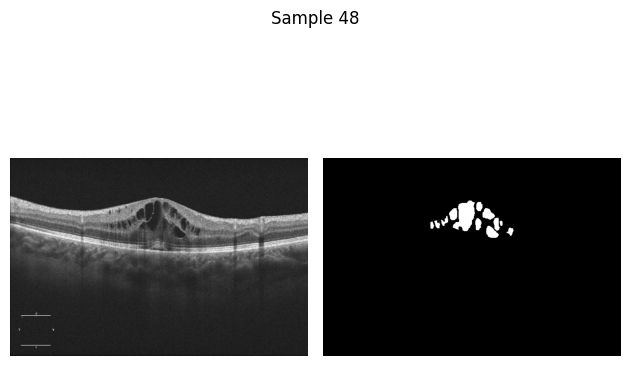

In [6]:
# Load some samples
simple_dataset = OCTDataset(f"{route}/OCT-dataset/images", f"{route}/OCT-dataset/masks")
print("Dataset len:", len(simple_dataset))
nsamples = 1
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")

## **Hasta aquí viene dado**

### Partición del dataset en entrenamiento/validación

In [7]:
from sklearn.model_selection import train_test_split
import glob
import os

image_path = "OCT-dataset/images"
mask_path = "OCT-dataset/masks"

all_images = glob.glob(os.path.join(image_path, '*.jpg'))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Número de imágenes de entrenamiento: {len(train_imgs)}")
print(f"Número de imágenes de validación: {len(val_imgs)}")

Número de imágenes de entrenamiento: 40
Número de imágenes de validación: 10


### Creación de los Dataset y DataLoader para cada partición

In [8]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación base para imágenes y máscaras (solo resize y tensorización)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Dataset modificado para usar solo las imágenes de cada split
class OCTSubsetDataset(OCTDataset):
    def __init__(self, img_list, image_path, mask_path, transform=None):
        self.img_files = img_list
        self.mask_files = [os.path.join(mask_path, os.path.basename(p)) for p in img_list]
        self.rsize = (416, 624)
        self.transform = transform

train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


### Entrenamiento de nuestro modelo UNet

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(input_channels=1, n_class=1).to(device)  # Output 1 canal para máscara binaria

# Binary Cross Entropy con logits (más estable)
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda:0


In [10]:
num_epochs = 50 # TODO: cambiar
best_val_loss = float('inf')
model_path = "best_unet_model.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluación en validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print("  ↳ Modelo guardado (el mejor hasta ahora)")

Epoch [1/50] | Train Loss: 1.3306 | Val Loss: 1.2983 | Time: 38.81
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/50] | Train Loss: 1.3295 | Val Loss: 1.2970 | Time: 9.3
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/50] | Train Loss: 1.3282 | Val Loss: 1.2957 | Time: 9.49
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/50] | Train Loss: 1.3266 | Val Loss: 1.2936 | Time: 9.36
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/50] | Train Loss: 1.3240 | Val Loss: 1.2898 | Time: 10.11
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/50] | Train Loss: 1.3189 | Val Loss: 1.2816 | Time: 9.65
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/50] | Train Loss: 1.3020 | Val Loss: 1.2423 | Time: 9.8
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/50] | Train Loss: 1.2090 | Val Loss: 1.0142 | Time: 9.86
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/50] | Train Loss: 1.0218 | Val Loss: 1.1188 | Time: 9.94
Epoch [10/50] | Train Loss: 0.9732 | Val Loss: 0.9144 | Time: 

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Función auxiliar para binarizar predicciones
def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

# Cargar mejor modelo
model.load_state_dict(torch.load(model_path))
model.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = get_binary_mask(outputs, threshold=thresh)

            # Flatten para calcular métricas
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    # Convertir a arrays
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    # Cálculo de métricas por pixel
    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = ((precision * recall)/(precision + recall))

    # print(f"IoU: {iou:.4f}")
    # print(f"Accuracy: {acc:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1 score: {f1:.4f}")

    results[i] = [thresh, iou, acc, precision, recall, f1]

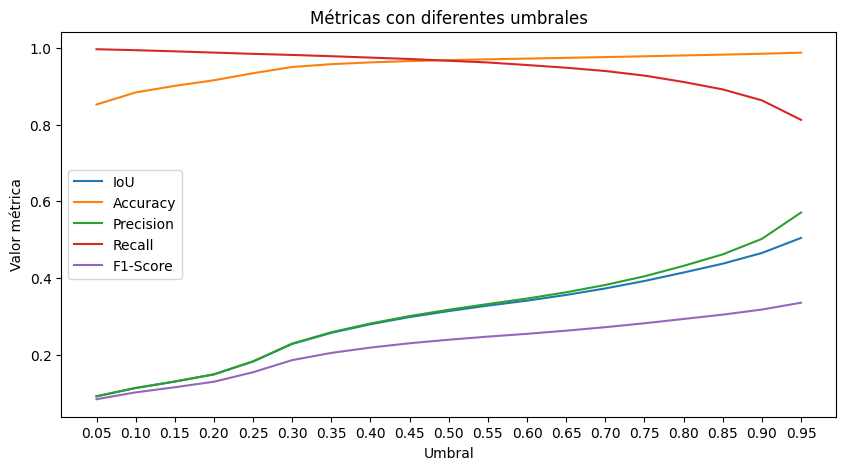

In [33]:
iou_results  = results[:, 1]
acc_results  = results[:, 2]
prec_results = results[:, 3]
rec_results  = results[:, 4]
f1_results   = results[:, 5]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, iou_results, label="IoU")
plt.plot(thresholds, acc_results, label="Accuracy")
plt.plot(thresholds, prec_results, label="Precision")
plt.plot(thresholds, rec_results, label="Recall")
plt.plot(thresholds, f1_results, label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.show()

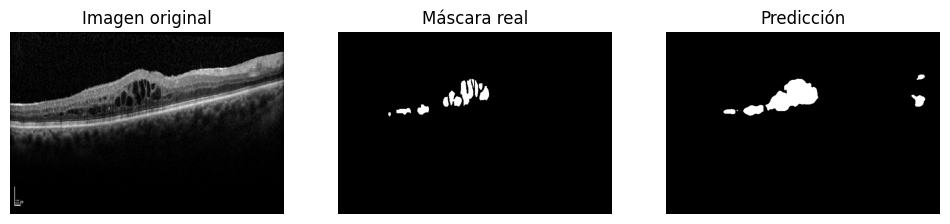

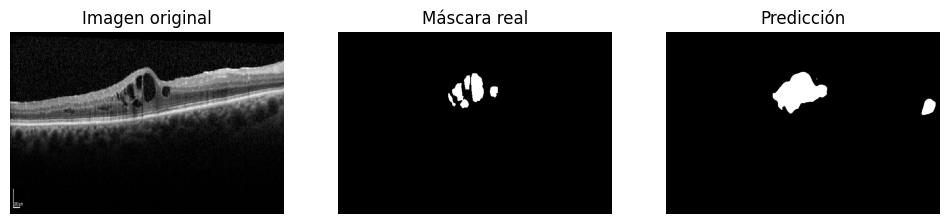

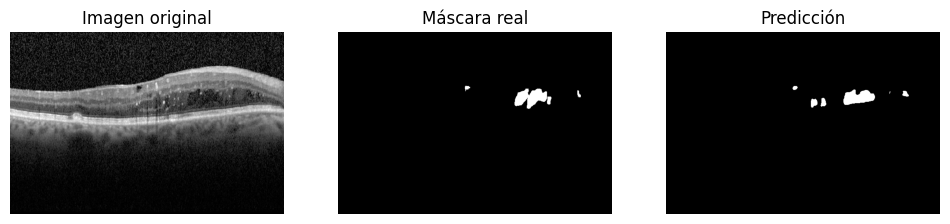

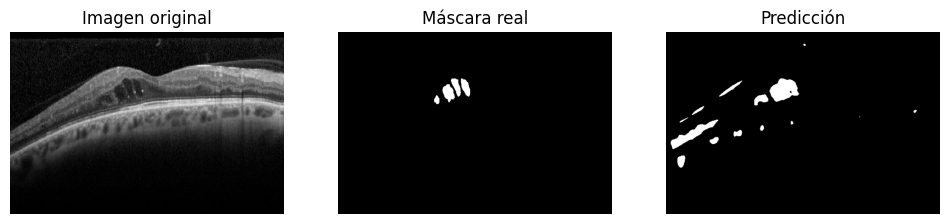

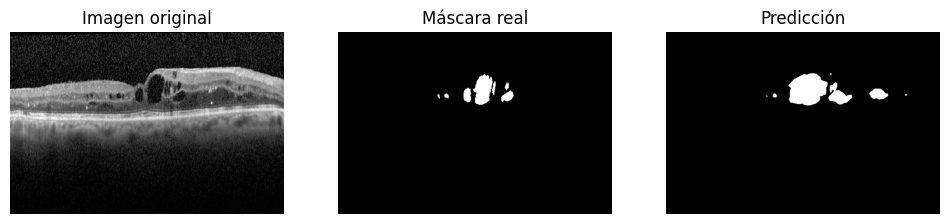

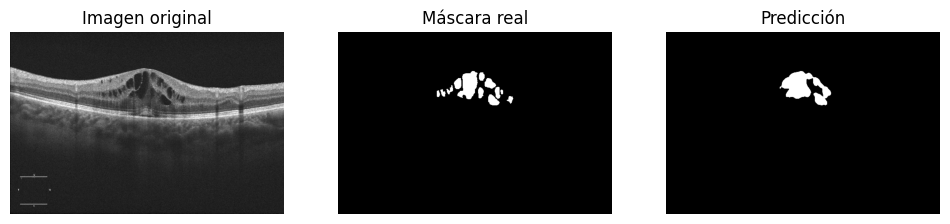

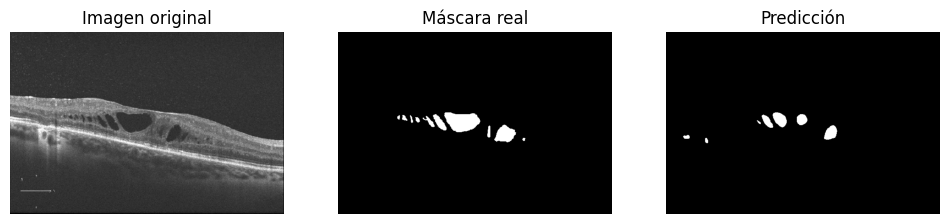

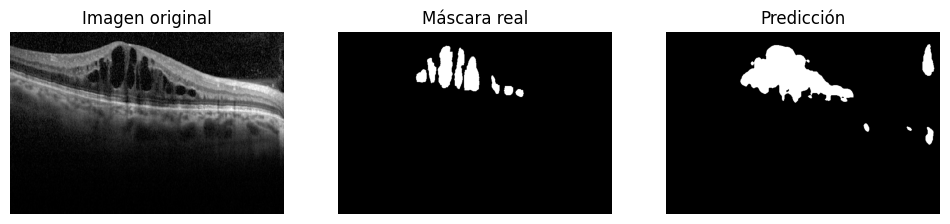

In [34]:
thresh = 0.9
# Mostrar ejemplos del conjunto de validación
num_samples = 8
model.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(num_samples, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción")
            for a in ax:
                a.axis('off')
            plt.show()

        break  # solo una tanda de imágenes